In [1]:
!pip install kaggle

In [34]:
!pip install squarify

In [2]:
from google.colab import files
from IPython.display import clear_output

files.upload()

! mkdir ~/.kaggle
! touch ~/.kaggle/kaggle.json
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d olistbr/brazilian-ecommerce

clear_output()
!ls /content

 brazilian-ecommerce.zip	    olist_order_reviews_dataset.csv
'kaggle (1).json'		    olist_orders_dataset.csv
 kaggle.json			    olist_products_dataset.csv
 olist_customers_dataset.csv	    olist_sellers_dataset.csv
 olist_geolocation_dataset.csv	    product_category_name_translation.csv
 olist_order_items_dataset.csv	    sample_data
 olist_order_payments_dataset.csv


In [5]:
! unzip brazilian-ecommerce.zip

Archive:  brazilian-ecommerce.zip
  inflating: olist_customers_dataset.csv  
  inflating: olist_geolocation_dataset.csv  
  inflating: olist_order_items_dataset.csv  
  inflating: olist_order_payments_dataset.csv  
  inflating: olist_order_reviews_dataset.csv  
  inflating: olist_orders_dataset.csv  
  inflating: olist_products_dataset.csv  
  inflating: olist_sellers_dataset.csv  
  inflating: product_category_name_translation.csv  


In [35]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime as dt

import seaborn as sns
sns.set(context="notebook", palette="colorblind", style = 'darkgrid' ,font_scale = 2, color_codes=True)

import matplotlib.pyplot as plt
%matplotlib inline

import squarify

import warnings
warnings.filterwarnings("ignore")

In [4]:
df_cust = pd.read_csv('/content/olist_customers_dataset.csv')
df_order_items = pd.read_csv('/content/olist_order_items_dataset.csv')
df_order_payments = pd.read_csv('/content/olist_order_payments_dataset.csv')
df_orders = pd.read_csv('/content/olist_orders_dataset.csv')

In [ ]:
my_df = [df_cust, df_order_items, df_order_payments, df_orders]

for df in my_df:
    print(df.info())
    print('='*75)
    print(df.isnull().sum())
    print('='*75)
    print(df.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB
None
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64
0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        11265

# Data Processing

In [5]:
# merge dataset

df_merge = (
    df_orders
        .merge(df_order_items, on='order_id')
        .merge(df_order_payments, on='order_id')
        .merge(df_cust, on='customer_id')
)

df_merge.shape

(117601, 22)

In [ ]:
print(df_merge.duplicated().sum())

0


In [ ]:
#check missing values

total_missing = df_merge.isnull().sum().sort_values(ascending=False)
percentage = (df_merge.isnull().sum()/df_merge.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total_missing, percentage], axis=1, keys=['Total', 'Percent'])
missing_data

,Total,Percent
order_delivered_customer_date,2567,0.021828
order_delivered_carrier_date,1245,0.010587
order_approved_at,15,0.000128
order_id,0,0.000000
freight_value,0,0.000000
customer_city,0,0.000000
customer_zip_code_prefix,0,0.000000
customer_unique_id,0,0.000000
payment_value,0,0.000000
payment_installments,0,0.000000


## Drop colums with missing value, as we don't need it

In [6]:
df_clean = df_merge.loc[:,('order_id', 'customer_id', 'order_status', 'order_purchase_timestamp', 'order_estimated_delivery_date',
       'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date',
       'price', 'freight_value', 'payment_sequential', 'payment_type',
       'payment_installments', 'payment_value', 'customer_unique_id',
       'customer_zip_code_prefix', 'customer_city', 'customer_state')]

df_clean.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-18 00:00:00,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,1,credit_card,1,18.12,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-18 00:00:00,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,3,voucher,1,2.00,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-18 00:00:00,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,2,voucher,1,18.59,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-08-13 00:00:00,1,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76,1,boleto,1,141.46,af07308b275d755c9edb36a90c618231,47813,barreiras,BA
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-09-04 00:00:00,1,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22,1,credit_card,3,179.12,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO


In [10]:
df_clean.isnull().sum()

order_id                         0
customer_id                      0
order_status                     0
order_purchase_timestamp         0
order_estimated_delivery_date    0
order_item_id                    0
product_id                       0
seller_id                        0
shipping_limit_date              0
price                            0
freight_value                    0
payment_sequential               0
payment_type                     0
payment_installments             0
payment_value                    0
customer_unique_id               0
customer_zip_code_prefix         0
customer_city                    0
customer_state                   0
dtype: int64

# Data Transformation

Main columns we need are: **customer_unique_id, order_id, payment_value, order_purchase_timestamp**

In [7]:
# convert date columns into datetime

to_datetime = df_clean.loc[:, ('order_purchase_timestamp',
                               'order_estimated_delivery_date')]

# convert object to datetime
for col in to_datetime:
    df_clean[col] = pd.to_datetime(df_clean[col], format='%Y-%m-%d %H:%M:%S')

## Exploratory Data Analysis ~ Part I

### 96.9% Customers are new customers, as they're only purchase once

In [ ]:
df_clean['fst_purchase_date'] = df_clean.groupby('customer_unique_id').order_purchase_timestamp.transform('min')
df_clean['is_fst_order'] =  df_clean.order_purchase_timestamp == df_clean['fst_purchase_date']

In [ ]:
print(df_clean.groupby([ 'is_fst_order'])['order_id'].nunique().to_frame() / df_clean.order_id.nunique())

              order_id
is_fst_order          
False         0.030132
True          0.969868


### How's the revenue, total customer per month?

In [ ]:
# max and min order_purchase_timestamp

print('Min Purchase Date:',df_clean.order_purchase_timestamp.dt.date.min(),
      'Max Purchase Date:',df_clean.order_purchase_timestamp.dt.date.max())

Min Purchase Date: 2016-09-04 Max Purchase Date: 2018-09-03


In [8]:
# Extract Year and Month from 'order_purchase_timestamp'
df_clean['order_purchase_year'] = df_clean.order_purchase_timestamp.apply(lambda x: x.strftime('%Y'))
df_clean['order_purchase_month'] = df_clean.order_purchase_timestamp.apply(lambda x: x.strftime('%M'))

# Changing the month attribute for correct ordenation
df_clean['month_year'] = df_clean['order_purchase_month'].astype(str).apply(lambda x: '0' + x if len(x) == 1 else x)
df_clean['month_year'] = df_clean['order_purchase_year'].astype(str) + '-' + df_clean['month_year'].astype(str)

# Creating year month column
df_clean['month_y'] = df_clean['order_purchase_timestamp'].map(lambda date: 100*date.year + date.month)

In [16]:
# calculate Revenue for each row and create a new dataframe with YearMonth - Revenue columns
df_revenue = df_clean.groupby(['month_y'])['payment_value'].sum().reset_index()

# using pct_change() function to see monthly percentage change
df_revenue['MonthlyGrowth'] = df_revenue['payment_value'].pct_change()

df_revenue

,month_y,payment_value,MonthlyGrowth
0,201609,347.52,NaN
1,201610,73914.58,211.691586
2,201612,19.62,-0.999735
3,201701,187779.41,9569.816004
4,201702,344134.79,0.832655
5,201703,526961.66,0.531265
6,201704,505665.53,-0.040413
7,201705,724504.55,0.432774
8,201706,600753.27,-0.170808
9,201707,737293.08,0.227281


Even after I drop columns with missing value, month 201611 still missing and value in month 201612 is weird. Furthermore month 201809 seems weird too.

What if we specified period only for data that make sense, which is only for data ranging from 201701 to 201808 (20 months)?

## Filter data to intended period

In [9]:
df_filtered = df_clean[(df_clean['order_purchase_timestamp'] > "2017-10-01 00:00:00") & (df_clean['order_purchase_timestamp'] < "2018-09-01 00:00:00")]
df_filtered.shape

(84826, 23)

## Exploratory Data Analysis ~ Part II

In [10]:
# calculate Revenue for each row and create a new dataframe with YearMonth - Revenue columns
df_revenue_filt = df_filtered.groupby(['month_y'])['payment_value'].sum().reset_index()

# using pct_change() function to see monthly percentage change
df_revenue_filt['MonthlyGrowth'] = df_revenue_filt['payment_value'].pct_change()

df_revenue_filt

,month_y,payment_value,MonthlyGrowth
0,201710,1021169.27,NaN
1,201711,1583869.01,0.551035
2,201712,1042855.86,-0.341577
3,201801,1408365.65,0.350489
4,201802,1306048.80,-0.072649
5,201803,1475599.95,0.129820
6,201804,1496811.52,0.014375
7,201805,1506974.84,0.006790
8,201806,1297594.81,-0.138941
9,201807,1351705.34,0.041701


In [11]:
# convert month_y from int to string (to avoid producing wrong plot)
df_revenue_filt['month_y'] = df_revenue_filt.month_y.astype(str)
df_revenue_filt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   month_y        11 non-null     object 
 1   payment_value  11 non-null     float64
 2   MonthlyGrowth  10 non-null     float64
dtypes: float64(2), object(1)
memory usage: 392.0+ bytes


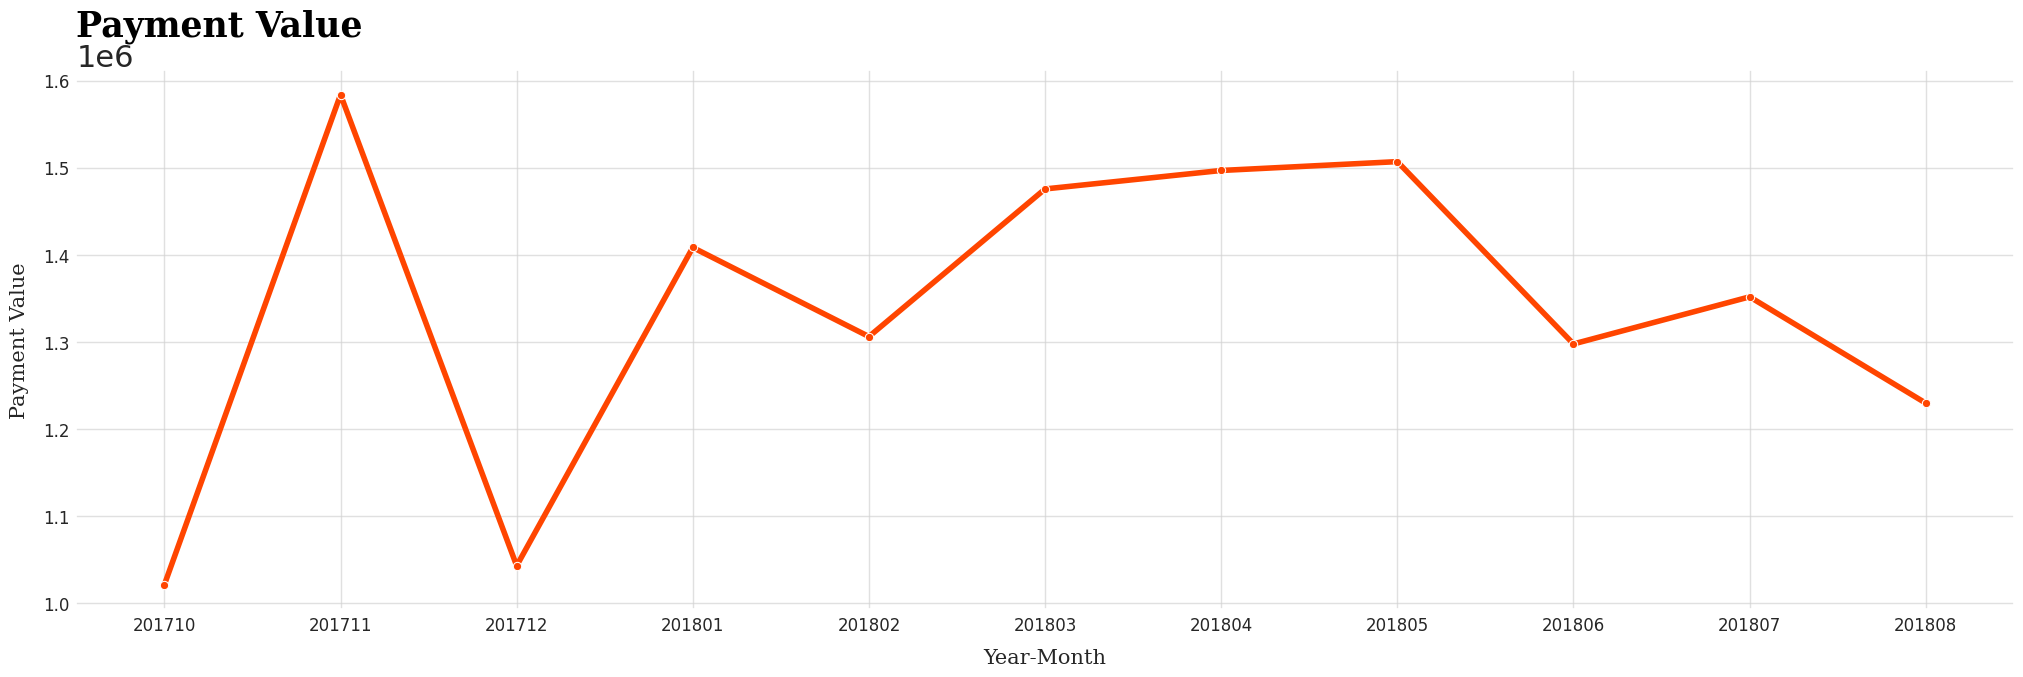

In [17]:
fig = plt.figure(figsize=(25, 7))
fig.set_facecolor("#fff")
ax = fig.add_subplot()
ax.set_facecolor("#fff")
ax.grid(color="lightgrey", alpha=0.7, linewidth=1, axis="both", zorder=0)
sns.lineplot(x="month_y", y="payment_value", color="orangered", marker='o', err_style=None, data=df_revenue_filt, linewidth=4, ax=ax, zorder=2)
ax.yaxis.set_tick_params(color="#000", labelsize=12, pad=5, length=0)
ax.set_ylabel("Payment Value", fontsize=15, fontfamily="serif", labelpad=10)
ax.set_xlabel("Year-Month", fontsize=15, fontfamily="serif", labelpad=10)
ax.xaxis.set_tick_params(color="#000", labelsize=12, pad=5, length=0)
ax.yaxis.set_tick_params(color="#000", labelsize=12, pad=5, length=0)
ax.set_title("Payment Value", loc="left", color="#000", fontsize=25, pad=5, fontweight="bold", fontfamily="serif", y=1.05, zorder=3)
fig.show()

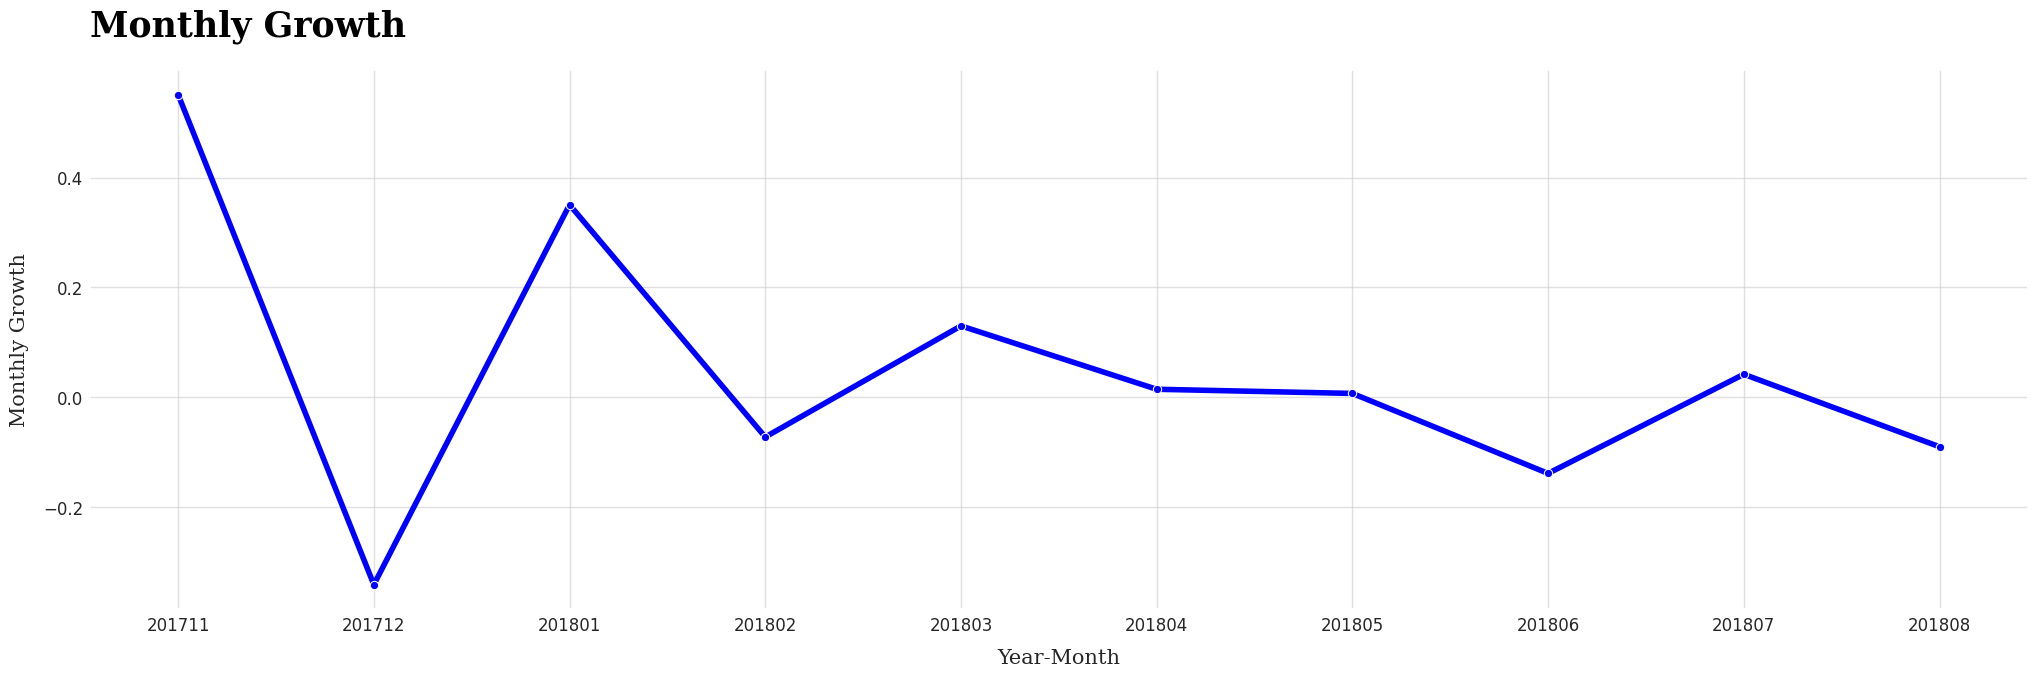

In [22]:
fig = plt.figure(figsize=(25, 7))
fig.set_facecolor("#fff")
ax = fig.add_subplot()
ax.set_facecolor("#fff")
ax.grid(color="lightgrey", alpha=0.7, linewidth=1, axis="both", zorder=0)
sns.lineplot(x="month_y", y="MonthlyGrowth", color="blue", marker='o', err_style=None, data=df_revenue_filt, linewidth=4, ax=ax, zorder=2)
ax.yaxis.set_tick_params(color="#000", labelsize=12, pad=5, length=0)
ax.set_ylabel("Monthly Growth", fontsize=15, fontfamily="serif", labelpad=10)
ax.set_xlabel("Year-Month", fontsize=15, fontfamily="serif", labelpad=10)
ax.xaxis.set_tick_params(color="#000", labelsize=12, pad=5, length=0)
ax.yaxis.set_tick_params(color="#000", labelsize=12, pad=5, length=0)
ax.set_title("Monthly Growth", loc="left", color="#000", fontsize=25, pad=5, fontweight="bold", fontfamily="serif", y=1.05, zorder=3)
fig.show()

In [18]:
#creating monthly active customers dataframe by counting unique Customer IDs
df_monthly_customer = df_filtered.groupby('month_y')['customer_unique_id'].nunique().reset_index()
df_monthly_customer

,month_y,customer_unique_id
0,201710,4501
1,201711,7342
2,201712,5557
3,201801,7120
4,201802,6537
5,201803,7096
6,201804,6878
7,201805,6795
8,201806,6121
9,201807,6211


In [19]:
# convert month_y from int to string (to avoid producing wrong plot)
df_monthly_customer['month_y'] = df_monthly_customer.month_y.astype(str)
df_monthly_customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   month_y             11 non-null     object
 1   customer_unique_id  11 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 304.0+ bytes


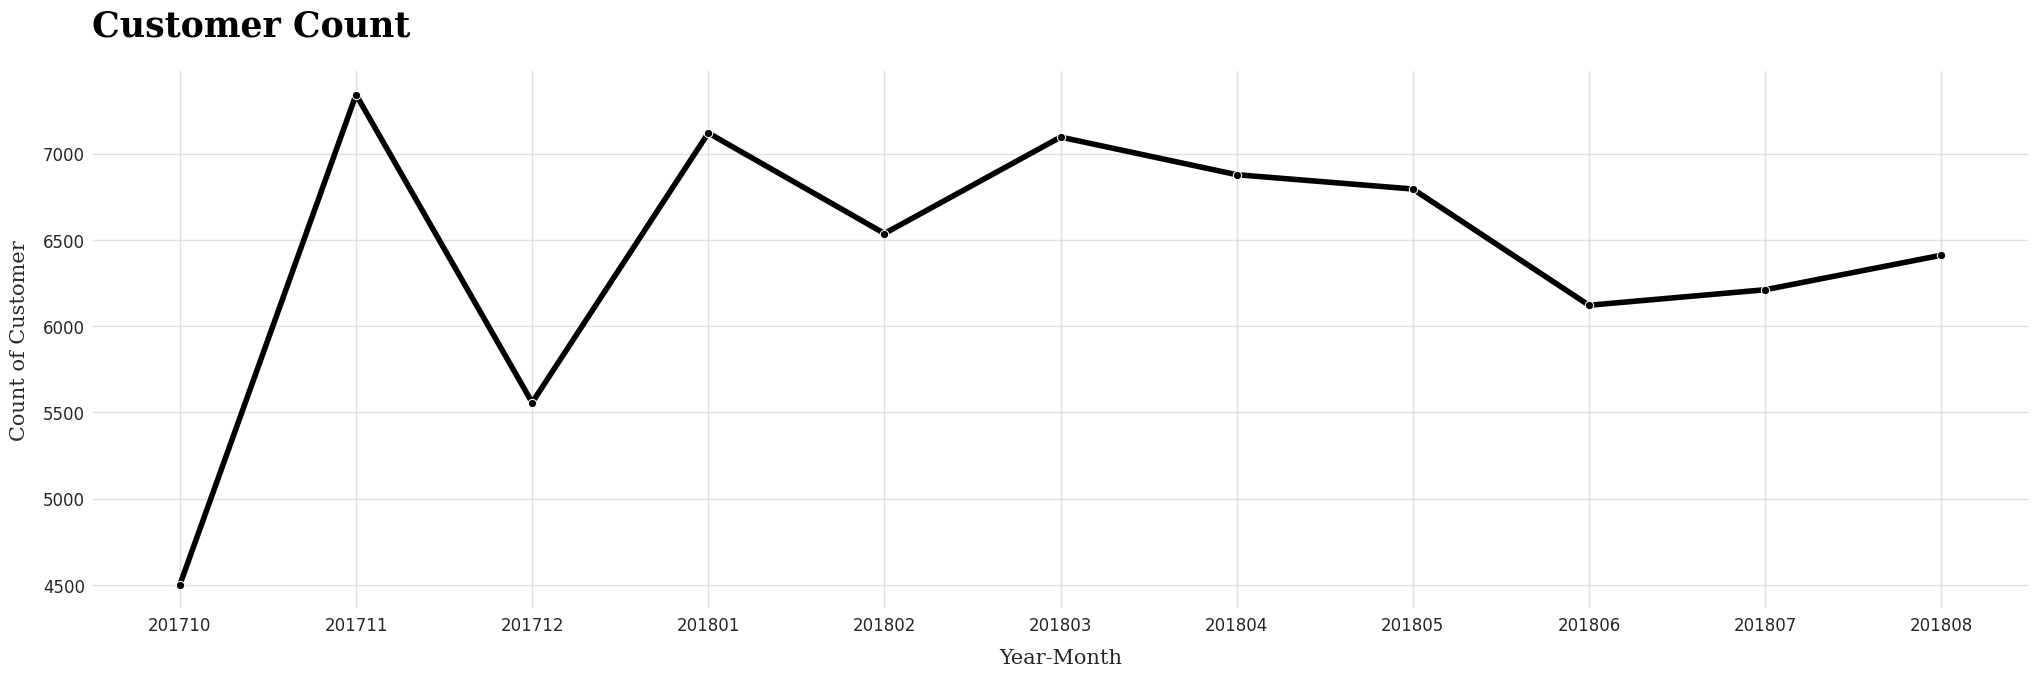

In [24]:
fig = plt.figure(figsize=(25, 7))
fig.set_facecolor("#fff")
ax = fig.add_subplot()
ax.set_facecolor("#fff")
ax.grid(color="lightgrey", alpha=0.7, linewidth=1, axis="both", zorder=0)
sns.lineplot(x="month_y", y="customer_unique_id", color="black", marker='o', err_style=None, data=df_monthly_customer, linewidth=4, ax=ax, zorder=2)
ax.yaxis.set_tick_params(color="#000", labelsize=12, pad=5, length=0)
ax.set_ylabel("Count of Customer", fontsize=15, fontfamily="serif", labelpad=10)
ax.set_xlabel("Year-Month", fontsize=15, fontfamily="serif", labelpad=10)
ax.xaxis.set_tick_params(color="#000", labelsize=12, pad=5, length=0)
ax.yaxis.set_tick_params(color="#000", labelsize=12, pad=5, length=0)
ax.set_title("Customer Count", loc="left", color="#000", fontsize=25, pad=5, fontweight="bold", fontfamily="serif", y=1.05, zorder=3)
fig.show()

# Column Recency

In [ ]:
df_filtered.customer_unique_id.duplicated().sum() #we need to drop these duplicated id to get the unique customer id

15237

In [26]:
# drop duplicates value in 'customer_unique_id' column
df_customers = df_filtered[['customer_unique_id']].drop_duplicates()

# get the max purchase date for each customer and create a dataframe with it
df_filtered['max_purchase_date'] = df_filtered.groupby('customer_unique_id').order_purchase_timestamp.transform('max')

# take our observation point as the max purchase date in our dataset
df_filtered['Recency'] = (df_filtered['max_purchase_date'].max() - df_filtered['max_purchase_date']).dt.days

# merge into df_customer
df_customers = pd.merge(
    df_customers,
    df_filtered[['customer_unique_id','Recency']].groupby(['customer_unique_id'],as_index=False).Recency.min(),
    on='customer_unique_id'
)

In [27]:
df_customers

,customer_unique_id,Recency
0,7c396fd4830fd04220f754e42b4e5bff,331
1,af07308b275d755c9edb36a90c618231,35
2,3a653a41f6f9fc3d2a113cf8398680e8,21
3,7c142cf63193a1473d2e66489a9ae977,283
4,72632f0f9dd73dfee390c9b22eb56dd6,196
...,...,...
69584,a49e8e11e850592fe685ae3c64b40eca,252
69585,c716cf2b5b86fb24257cffe9e7969df8,328
69586,da62f9e57a76d978d02ab5362c509660,204
69587,5097a5312c8b157bb7be58ae360ef43c,232


# Column Frequency

In [28]:
# get order counts for each user and create a dataframe with it
df_filtered['n_order_items'] = df_filtered.groupby('order_id').order_item_id.transform('max')

n_items_per_user = df_filtered.groupby('customer_unique_id',as_index=False).n_order_items.sum().rename(columns={'n_order_items':'Frequency'})

# add 'Frequency' column into df_customers
df_customers = df_customers.merge(n_items_per_user, how='inner', on='customer_unique_id')

In [29]:
df_customers

,customer_unique_id,Recency,Frequency
0,7c396fd4830fd04220f754e42b4e5bff,331,3
1,af07308b275d755c9edb36a90c618231,35,1
2,3a653a41f6f9fc3d2a113cf8398680e8,21,1
3,7c142cf63193a1473d2e66489a9ae977,283,1
4,72632f0f9dd73dfee390c9b22eb56dd6,196,1
...,...,...,...
69584,a49e8e11e850592fe685ae3c64b40eca,252,1
69585,c716cf2b5b86fb24257cffe9e7969df8,328,8
69586,da62f9e57a76d978d02ab5362c509660,204,1
69587,5097a5312c8b157bb7be58ae360ef43c,232,4


# Column Monetary

In [30]:
df_revenue_mont = df_filtered.groupby('customer_unique_id', as_index=False).payment_value.sum().rename(columns={'payment_value':"Monetary"})

#merge it with our main dataframe
df_customers = pd.merge(df_customers, df_revenue_mont, on='customer_unique_id')

In [31]:
df_customers

,customer_unique_id,Recency,Frequency,Monetary
0,7c396fd4830fd04220f754e42b4e5bff,331,3,38.71
1,af07308b275d755c9edb36a90c618231,35,1,141.46
2,3a653a41f6f9fc3d2a113cf8398680e8,21,1,179.12
3,7c142cf63193a1473d2e66489a9ae977,283,1,72.20
4,72632f0f9dd73dfee390c9b22eb56dd6,196,1,28.62
...,...,...,...,...
69584,a49e8e11e850592fe685ae3c64b40eca,252,1,71.04
69585,c716cf2b5b86fb24257cffe9e7969df8,328,8,213.58
69586,da62f9e57a76d978d02ab5362c509660,204,1,195.00
69587,5097a5312c8b157bb7be58ae360ef43c,232,4,882.32


In [ ]:
# df_customers.to_csv('brazil_ecommerce_rfm_filtered.csv')

##  Exploratory Data Analysis ~ Part III

In [ ]:
df_customers.info() # from 93341 rows to 69589 after filtering

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69589 entries, 0 to 69588
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   customer_unique_id  69589 non-null  object 
 1   Recency             69589 non-null  int64  
 2   Frequency           69589 non-null  int64  
 3   Monetary            69589 non-null  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 2.7+ MB


In [ ]:
# statistics summary
df_customers.describe()

,Recency,Frequency,Monetary
count,69589.000000,69589.000000,69589.000000
mean,161.638607,1.708115,211.536863
std,92.477954,4.173797,545.715074
min,0.000000,1.000000,9.590000
25%,82.000000,1.000000,63.700000
50%,162.000000,1.000000,113.350000
75%,237.000000,1.000000,201.080000
max,332.000000,400.000000,44048.000000


Distribution plot of: Recency


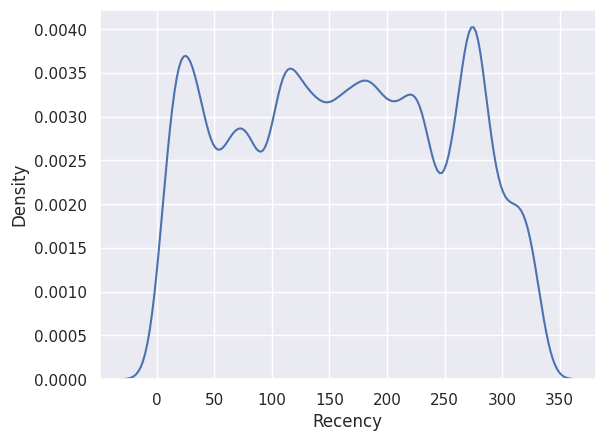

Distribution plot of: Frequency


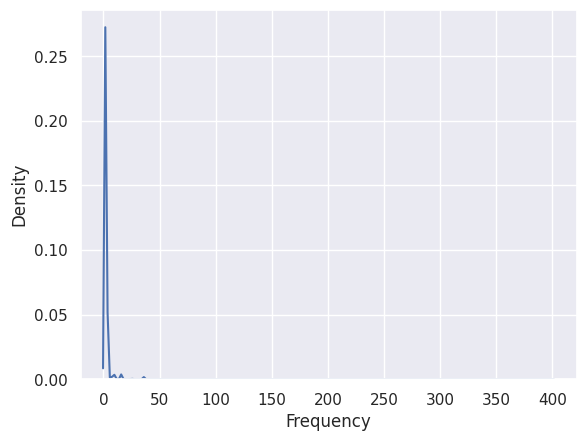

Distribution plot of: Monetary


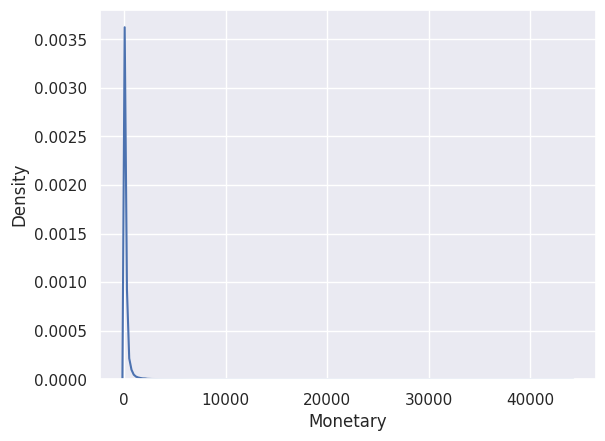

In [ ]:
# recency, frequency, and monetary distribution

df_explore = df_customers[['Recency', 'Frequency', 'Monetary']]

for i, var in enumerate(df_explore):
    print('Distribution plot of:', var)
    sns.despine(left=True)
    sns.distplot(df_explore[var], hist=False, color="b")
    plt.show()

# RFM Segments and RFM Score

In [39]:
# set customer_unique_id as index
rfm = df_customers.set_index('customer_unique_id')
rfm

,Recency,Frequency,Monetary
customer_unique_id,,,
7c396fd4830fd04220f754e42b4e5bff,331,3,38.71
af07308b275d755c9edb36a90c618231,35,1,141.46
3a653a41f6f9fc3d2a113cf8398680e8,21,1,179.12
7c142cf63193a1473d2e66489a9ae977,283,1,72.20
72632f0f9dd73dfee390c9b22eb56dd6,196,1,28.62
...,...,...,...
a49e8e11e850592fe685ae3c64b40eca,252,1,71.04
c716cf2b5b86fb24257cffe9e7969df8,328,8,213.58
da62f9e57a76d978d02ab5362c509660,204,1,195.00


In [40]:
my_rfm = rfm.copy()

In [ ]:
# observe the value count for each unique value in each column
for i, var in enumerate(my_rfm):
    print(my_rfm[var].value_counts())
    print('='*75)

277    838
278    717
275    416
274    396
105    363
      ... 
3       66
1       61
247     49
240     47
0       29
Name: Recency, Length: 333, dtype: int64
1      59605
4       5016
2       2505
9        899
16       321
3        261
5        251
8        155
25       138
36       130
10        52
6         34
12        24
7         20
17        17
18        17
49        17
13        15
11        10
37         8
64         7
20         7
100        7
144        7
32         5
50         5
24         4
14         4
26         4
45         4
41         3
19         3
81         3
61         3
72         3
30         2
40         2
22         2
121        2
196        2
234        1
169        1
48         1
147        1
53         1
63         1
69         1
29         1
15         1
125        1
137        1
28         1
34         1
38         1
400        1
Name: Frequency, dtype: int64
99.90     107
35.00     101
77.57      97
67.50      92
116.94     78
         ... 
255.72   

In [41]:
# create RFM segment using quartile
r_labels=range(4,0,-1)
f_labels=range(1,5)
m_labels=range(1,5)

r_quartiles = pd.qcut(my_rfm['Recency'], q=4, labels = r_labels)
f_quartiles = pd.qcut(my_rfm['Frequency'].rank(method='first'), q=4, labels = f_labels, duplicates='drop')
m_quartiles = pd.qcut(my_rfm['Monetary'].rank(method='first'), q=4, labels = m_labels, duplicates='drop')

In [ ]:
r_quartiles

# higher the number represent higher frequency and monetary [1 < 2 < 3 < 4]
# in recency, if we got R=321 then the customer last purchase time is 321 days ago. this will return R=1 (the least value)
# the percentile for recency works the same just like frequency and monetary (R=4 indicates the most recent purchase time), then higher the R score the better it is

customer_unique_id
7c396fd4830fd04220f754e42b4e5bff    1
af07308b275d755c9edb36a90c618231    4
3a653a41f6f9fc3d2a113cf8398680e8    4
7c142cf63193a1473d2e66489a9ae977    1
72632f0f9dd73dfee390c9b22eb56dd6    2
                                   ..
a49e8e11e850592fe685ae3c64b40eca    1
c716cf2b5b86fb24257cffe9e7969df8    1
da62f9e57a76d978d02ab5362c509660    2
5097a5312c8b157bb7be58ae360ef43c    2
60350aa974b26ff12caad89e55993bd6    2
Name: Recency, Length: 69589, dtype: category
Categories (4, int64): [4 < 3 < 2 < 1]

In [42]:
my_rfm = my_rfm.assign(R=r_quartiles,F=f_quartiles,M=m_quartiles)

# Build RFM Segment and RFM Score
my_rfm['RFM_Segment'] = my_rfm['R'].astype(str) +\
                      my_rfm['F'].astype(str) +\
                      my_rfm['M'].astype(str)

my_rfm['RFM_Score'] = my_rfm[['R','F','M']].sum(axis=1)

my_rfm

,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score
customer_unique_id,,,,,,,,
7c396fd4830fd04220f754e42b4e5bff,331,3,38.71,1,4,1,141,6
af07308b275d755c9edb36a90c618231,35,1,141.46,4,1,3,413,8
3a653a41f6f9fc3d2a113cf8398680e8,21,1,179.12,4,1,3,413,8
7c142cf63193a1473d2e66489a9ae977,283,1,72.20,1,1,2,112,4
72632f0f9dd73dfee390c9b22eb56dd6,196,1,28.62,2,1,1,211,4
...,...,...,...,...,...,...,...,...
a49e8e11e850592fe685ae3c64b40eca,252,1,71.04,1,4,2,142,7
c716cf2b5b86fb24257cffe9e7969df8,328,8,213.58,1,4,4,144,9
da62f9e57a76d978d02ab5362c509660,204,1,195.00,2,4,3,243,9


In [ ]:
# Mean for each RFM Score
my_rfm.groupby('RFM_Score').agg(
    #customers=('customer_unique_id', 'count'),
    mean_recency=('Recency', 'mean'),
    mean_frequency=('Frequency', 'mean'),
    mean_monetary=('Monetary', 'mean'),
    count_monetary=('Monetary', 'count')
).round(3)

,mean_recency,mean_frequency,mean_monetary,count_monetary
RFM_Score,,,,
3,281.806,1.000,44.299,1162
4,253.934,1.000,57.894,3769
5,229.036,1.000,74.125,7284
6,194.150,1.022,105.954,10948
7,163.844,1.049,131.997,12374
8,138.136,1.142,172.185,11706
9,136.663,2.226,309.797,10130
10,113.431,2.856,381.039,6360
11,86.472,4.221,551.128,3899


## RFM Segments Definition

In [ ]:
# based on R and F value, skip the M value as it works similar just like the F value

seg_map = {
    r'[1-2][1-2]': 'Hibernating',
    r'[1-2]3': 'At Risk',
    r'[1-2]4': 'Can\'t Loose',
    r'31': 'About to Sleep',
    r'33': 'Need Attention',
    r'[3-4][4-5]': 'Loyal Customers',
    r'41': 'Promising',
    r'32': 'New Customers',
    r'[4-5]2': 'Potential Loyalists',
    r'43': 'Champions'
}

## RFM Score Grouping

In [ ]:
my_rfm['Segment'] = my_rfm['R'].astype(str) + my_rfm['F'].astype(str)
my_rfm['Segment check'] = my_rfm['Segment']
my_rfm['Segment'] = my_rfm['Segment'].replace(seg_map, regex=True)
my_rfm.head()

,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score,Segment,Segment check
customer_unique_id,,,,,,,,,,
7c396fd4830fd04220f754e42b4e5bff,331,3,38.71,1,4,1,141,6,Can't Loose,14
af07308b275d755c9edb36a90c618231,35,1,141.46,4,1,3,413,8,Promising,41
3a653a41f6f9fc3d2a113cf8398680e8,21,1,179.12,4,1,3,413,8,Promising,41
7c142cf63193a1473d2e66489a9ae977,283,1,72.20,1,1,2,112,4,Hibernating,11
72632f0f9dd73dfee390c9b22eb56dd6,196,1,28.62,2,1,1,211,4,Hibernating,21


In [ ]:
# RFM mean for each segment
my_rfm.groupby('Segment').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
}).round(3)

,Recency,Frequency,Monetary
Segment,,,
About to Sleep,124.536,1.000,160.842
At Risk,241.796,1.000,148.813
Can't Loose,241.381,3.836,382.615
Champions,40.507,1.000,151.545
Hibernating,241.135,1.000,146.599
Loyal Customers,83.912,3.829,403.448
Need Attention,124.183,1.000,152.458
New Customers,123.936,1.000,154.584
Potential Loyalists,40.435,1.000,150.467


In [ ]:
#count total customer for each segment
rfm_viz = my_rfm.copy()
rfm_viz['customer_unique_id'] = rfm_viz.index
#calculate sum of points for each team
rfm_viz = rfm_viz[['Segment','customer_unique_id']].groupby(['Segment']).count()
rfm_viz

,customer_unique_id
Segment,
About to Sleep,4348
At Risk,8778
Can't Loose,8612
Champions,4347
Hibernating,17278
Loyal Customers,8785
Need Attention,4272
New Customers,4345
Potential Loyalists,4418


In [ ]:
#save above calculation into new df
bar_quest = rfm_viz.sort_values(ascending=False, by='customer_unique_id').reset_index()
bar_quest.rename(columns={'Segment': 'Segment Type',
                        'customer_unique_id': 'Count of Customer'}, inplace=True)
bar_quest

,Segment Type,Count of Customer
0,Hibernating,17278
1,Loyal Customers,8785
2,At Risk,8778
3,Can't Loose,8612
4,Potential Loyalists,4418
5,Promising,4406
6,About to Sleep,4348
7,Champions,4347
8,New Customers,4345
9,Need Attention,4272


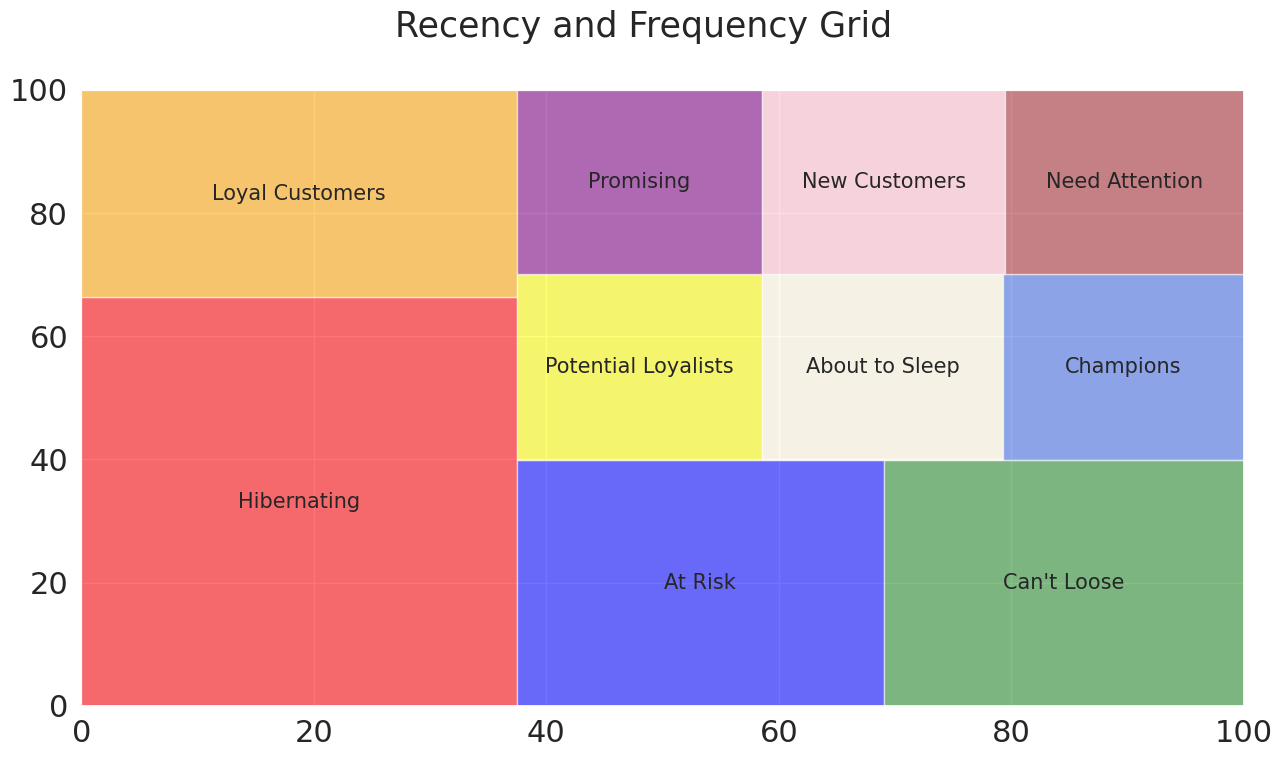

In [ ]:
# Treemap by count of customer id
plt.figure(figsize=(15,8))
plt.rc('font', size=15)
squarify.plot(sizes=bar_quest['Count of Customer'], label=bar_quest['Segment Type'],
              color=["red","orange","blue", "forestgreen", "yellow", "purple", "cornsilk","royalblue", "pink", "brown"], alpha=.55)
plt.suptitle("Recency and Frequency Grid", fontsize=25);

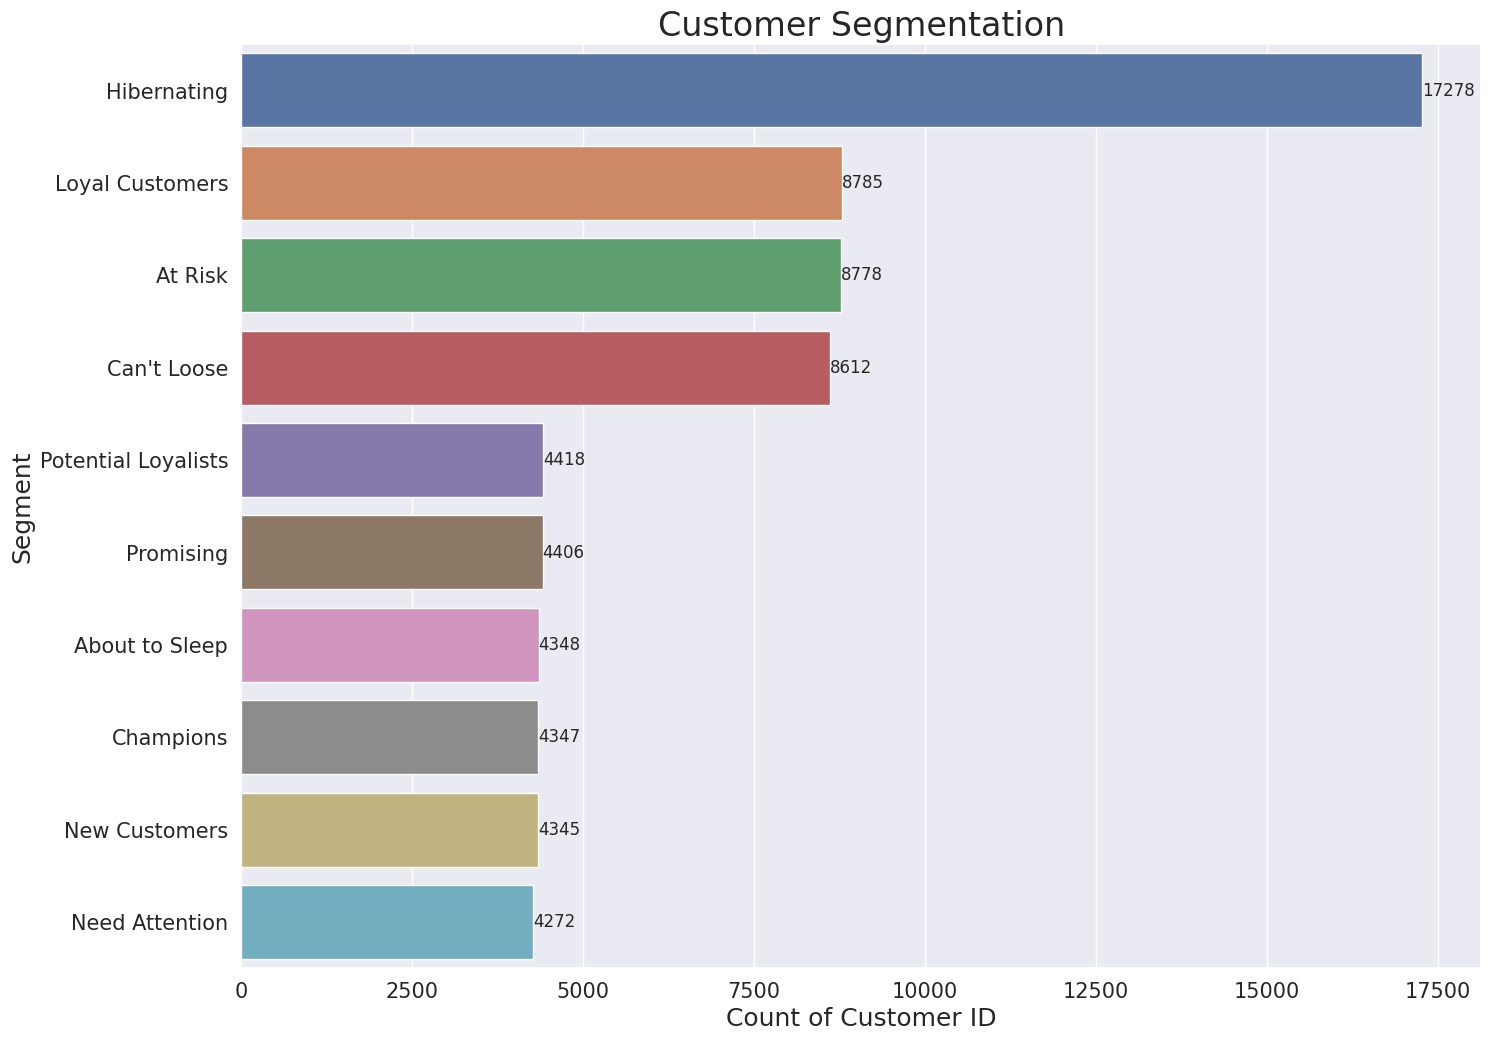

In [ ]:
#visualize count of customer id per segment
#trying to sort it descending, also show its value

sns.set()
fig = plt.figure(figsize = (16,12))
g = sns.barplot(y='Segment Type',
                x='Count of Customer',
                data=bar_quest,
                errorbar=None)
g.bar_label(g.containers[0])
plt.title('Customer Segmentation', fontsize = 24)
plt.xlabel('Count of Customer ID', fontsize = 18)
plt.ylabel('Segment', fontsize = 18)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.show()

Above methods doesn't perform well in segmenting customers into 10 segments as the difference of customer count in each segment is relatively small. **Perhaps severe skewness in Frequency and Monetary table is the main cause, or it could be we have too many segments (in this case 10 segments). Would it be different if we have fewer segments?)**.

## Reducing the number of segments (from 10 to 6 + 1 (Other segment))

In [44]:
rfm_copy = my_rfm.copy()
#rfm_copy = rfm_copy.drop(columns=['Segment', 'Segment check'], axis=1)
rfm_copy

,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score
customer_unique_id,,,,,,,,
7c396fd4830fd04220f754e42b4e5bff,331,3,38.71,1,4,1,141,6
af07308b275d755c9edb36a90c618231,35,1,141.46,4,1,3,413,8
3a653a41f6f9fc3d2a113cf8398680e8,21,1,179.12,4,1,3,413,8
7c142cf63193a1473d2e66489a9ae977,283,1,72.20,1,1,2,112,4
72632f0f9dd73dfee390c9b22eb56dd6,196,1,28.62,2,1,1,211,4
...,...,...,...,...,...,...,...,...
a49e8e11e850592fe685ae3c64b40eca,252,1,71.04,1,4,2,142,7
c716cf2b5b86fb24257cffe9e7969df8,328,8,213.58,1,4,4,144,9
da62f9e57a76d978d02ab5362c509660,204,1,195.00,2,4,3,243,9


In [45]:
# Setting up the label for each client and adding the column "Label" to the dataframe

label = [0] * len(rfm_copy)

for i in range(0,len(rfm_copy)):

    if rfm_copy['RFM_Segment'][i] == '111':
        label[i] = "Best Customers"

    elif rfm_copy['RFM_Segment'][i] == '134' :
        label[i] = "Almost Lost"

    elif rfm_copy['RFM_Segment'][i] == '344':
        label[i] = "Lost Customers"

    elif rfm_copy['RFM_Segment'][i] == '444':
        label[i] = "Lost Cheap Customers"

    elif rfm_copy['F'][i] == 1:
        label[i] = "Loyal Customers"

    elif rfm_copy['M'][i] == 1:
        label[i] = "Big Spenders"

    else:
        label[i] = "Others"

In [46]:
rfm_copy['Segment'] = label
rfm_copy

,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score,Segment
customer_unique_id,,,,,,,,,
7c396fd4830fd04220f754e42b4e5bff,331,3,38.71,1,4,1,141,6,Big Spenders
af07308b275d755c9edb36a90c618231,35,1,141.46,4,1,3,413,8,Loyal Customers
3a653a41f6f9fc3d2a113cf8398680e8,21,1,179.12,4,1,3,413,8,Loyal Customers
7c142cf63193a1473d2e66489a9ae977,283,1,72.20,1,1,2,112,4,Loyal Customers
72632f0f9dd73dfee390c9b22eb56dd6,196,1,28.62,2,1,1,211,4,Loyal Customers
...,...,...,...,...,...,...,...,...,...
a49e8e11e850592fe685ae3c64b40eca,252,1,71.04,1,4,2,142,7,Others
c716cf2b5b86fb24257cffe9e7969df8,328,8,213.58,1,4,4,144,9,Others
da62f9e57a76d978d02ab5362c509660,204,1,195.00,2,4,3,243,9,Others


In [ ]:
# RFM mean for each segment
rfm_copy.groupby('Segment').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
}).round(3)

,Recency,Frequency,Monetary
Segment,,,
Almost Lost,283.771,1.000,416.398
Best Customers,281.806,1.000,44.299
Big Spenders,162.489,1.063,43.738
Lost Cheap Customers,42.147,6.097,711.094
Lost Customers,123.268,6.383,773.850
Loyal Customers,152.822,1.000,160.998
Others,167.657,1.774,233.203


In [47]:
#count total customer for each segment
rfm_viz_s7 = rfm_copy.copy()
rfm_viz_s7['customer_unique_id'] = rfm_viz_s7.index
#calculate sum of points for each team
rfm_viz_s7 = rfm_viz_s7[['Segment','customer_unique_id']].groupby(['Segment']).count()
rfm_viz_s7

,customer_unique_id
Segment,
Almost Lost,824
Best Customers,1162
Big Spenders,12514
Lost Cheap Customers,1957
Lost Customers,2162
Loyal Customers,16236
Others,34734


In [48]:
#save above calculation into new df
bar_quest_s7 = rfm_viz_s7.sort_values(ascending=False, by='customer_unique_id').reset_index()
bar_quest_s7.rename(columns={'Segment': 'Segment Type',
                        'customer_unique_id': 'Count of Customer'}, inplace=True)
bar_quest_s7

,Segment Type,Count of Customer
0,Others,34734
1,Loyal Customers,16236
2,Big Spenders,12514
3,Lost Customers,2162
4,Lost Cheap Customers,1957
5,Best Customers,1162
6,Almost Lost,824


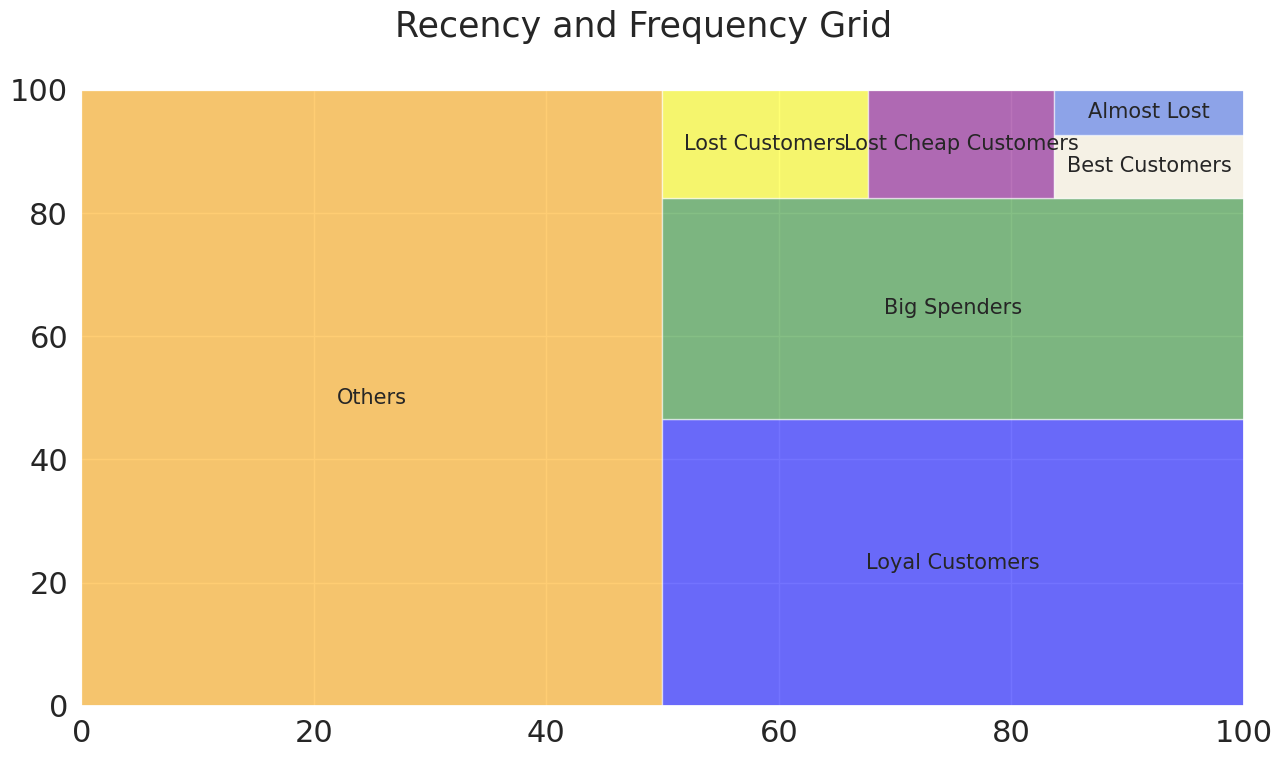

In [49]:
# Treemap by count of customer id
plt.figure(figsize=(15,8))
plt.rc('font', size=15)
squarify.plot(sizes=bar_quest_s7['Count of Customer'], label=bar_quest_s7['Segment Type'],
              color=["orange","blue", "forestgreen", "yellow", "purple", "cornsilk","royalblue"], alpha=.55)
plt.suptitle("Recency and Frequency Grid", fontsize=25);

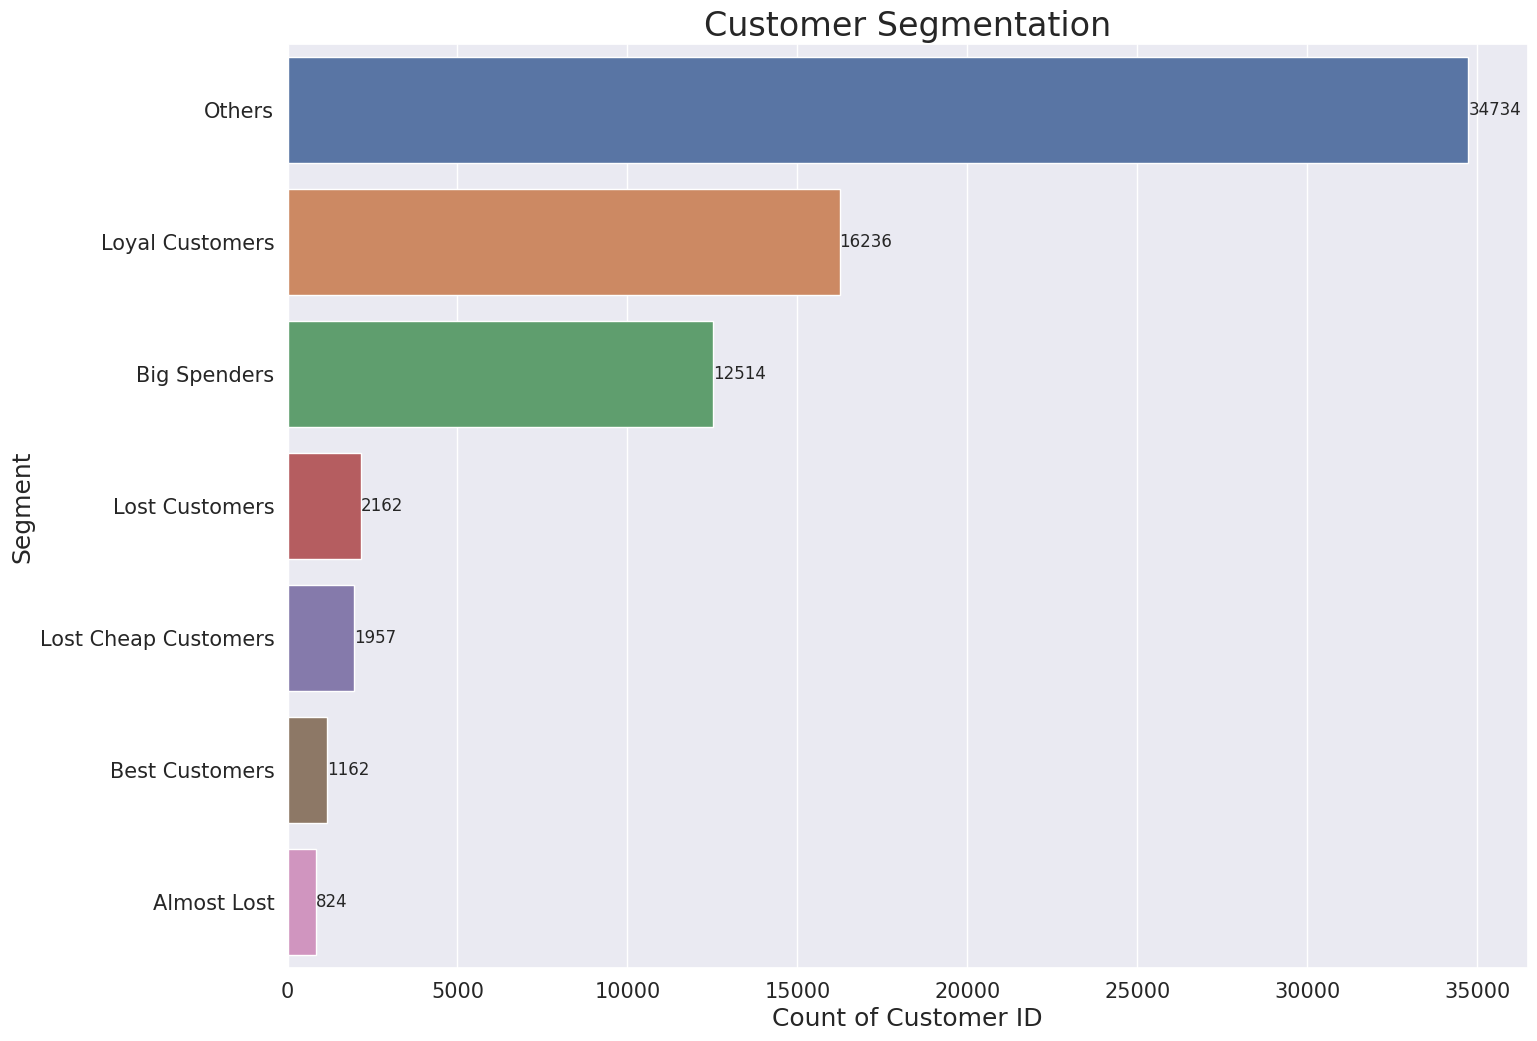

In [ ]:
sns.set()
fig = plt.figure(figsize = (16,12))
g = sns.barplot(y='Segment Type',
                x='Count of Customer',
                data=bar_quest_s7,
                errorbar=None)
g.bar_label(g.containers[0])
plt.title('Customer Segmentation', fontsize = 24)
plt.xlabel('Count of Customer ID', fontsize = 18)
plt.ylabel('Segment', fontsize = 18)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.show()

Hmm it's quite challenging dropping number of segments from 10 to 6 (actually 7
because the last segment is Others a.k.a we can't interpret it). Okay, the number of customer id in each segment is relatively splitted. But, **the main issue we have with 7 segments is 'Other' segment has the most member, which make it hard to interpret**.